In [1]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
pd.set_option('display.max_colwidth', None)
import glob
import datetime
from config_loader import (
    D_CONFIG, DATASET_TOP_PATH,
    DATASET_SITE_PATH, PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    DATASET_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH,
    RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH
    )

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
from feature_transformation import *
from utils import load_data_dict_json
deployment_code_dir = os.path.join('/home', 'prash', 'clinical_deterioration')
sys.path.append(deployment_code_dir)
sys.path.append(os.path.join(deployment_code_dir, 'src_code'))
sys.path.append(os.path.join(deployment_code_dir, 'data_example'))
sys.path.append(os.path.join(deployment_code_dir, 'src_code', 'utils_specs'))
import onnxruntime as rt

RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH = os.path.join(RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH, 'lightGBM')
CLF_TRAIN_TEST_SPLIT_PATH=os.path.join(DATASET_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH, 'classifier_train_test_split')

In [2]:
CLF_TRAIN_TEST_SPLIT_PATH

'/home/prash/datasets/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split'

## Load the raw data as well as featurized data for a test participant

In [115]:
x_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'x_test.csv.gz'), nrows=5000)
y_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv.gz'), nrows=5000)

test_adm_id = 15292953#14322696#15469566
x_test_df = x_test_df[x_test_df.hospital_admission_id==test_adm_id].reset_index(drop=True)
y_test_df = y_test_df[y_test_df.hospital_admission_id==test_adm_id].reset_index(drop=True)

In [116]:
x_test_df

,patient_id,hospital_admission_id,facility_code,start,stop,blood_glucose_concentration_std_90-100,blood_glucose_concentration_time_since_measured_90-100,blood_glucose_concentration_count_90-100,blood_glucose_concentration_slope_90-100,blood_glucose_concentration_median_90-100,...,various_other_medication_slope_0-100,various_other_medication_median_0-100,various_other_medication_min_0-100,various_other_medication_max_0-100,various_other_medication_last_value_measured_0-100,birth_date,admission_timestamp,age_at_admission,gender_is_male,gender_is_unknown
0,1281033,15292953,1,-24.0,-12.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
1,1281033,15292953,1,-24.0,0.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
2,1281033,15292953,1,-24.0,12.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
3,1281033,15292953,1,-24.0,24.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
4,1281033,15292953,1,-24.0,36.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
5,1281033,15292953,1,-24.0,48.0,10.000000,-24.000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
6,1281033,15292953,1,-24.0,60.0,96.303880,1.176,8.0,-41.190838,422.5,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
7,1281033,15292953,1,-24.0,72.0,52.000000,0.480,2.0,15.453195,185.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
8,1281033,15292953,1,-24.0,84.0,0.000000,10.370,1.0,0.000000,309.0,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0
9,1281033,15292953,1,-24.0,96.0,11.500000,5.443,2.0,-9.094503,353.5,...,0.0,0.0,0.0,0.0,0.0,1951-06-18,2022-08-28 19:18:00,71.243835,0.0,0.0


In [117]:
vitals_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'vitals_before_icu.csv.gz'))
labs_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'labs_before_icu.csv.gz'))
medications_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'medications_before_icu.csv.gz'))
demographics_df = pd.read_csv(os.path.join(DATASET_SITE_PATH, 'demographics_before_icu.csv.gz'))

demographics_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Demographics.json'))
vitals_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Vitals.json'))
labs_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Labs.json'))
medications_dd = load_data_dict_json(os.path.join(DATASET_SITE_PATH,
                                                  'Spec-Medication-Orders.json'))

collapsed_features_dd = load_data_dict_json(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'Spec_features.json'))
collapsed_features = parse_feature_cols(collapsed_features_dd)

vitals_df = vitals_df[vitals_df.hospital_admission_id==test_adm_id].reset_index(drop=True)
labs_df = labs_df[labs_df.hospital_admission_id==test_adm_id].reset_index(drop=True)
medications_df = medications_df[medications_df.hospital_admission_id==test_adm_id].reset_index(drop=True)
demographics_df = demographics_df[demographics_df.hospital_admission_id==test_adm_id].reset_index(drop=True)


vital_cols = parse_feature_cols(vitals_dd)
lab_cols = parse_feature_cols(labs_dd)
medication_cols = parse_feature_cols(medications_dd)
demographic_cols = parse_feature_cols(demographics_dd)
id_cols = parse_id_cols(vitals_dd)
time_col = parse_time_cols(vitals_dd)[-1]

In [118]:
demographics_df

,patient_id,hospital_admission_id,facility_code,birth_date,admission_timestamp,age_at_admission,gender_is_male,gender_is_unknown
0,1281033,15292953,1,1951-06-18,2022-08-28 19:18:00,71.243836,0.0,0.0


## Create an artificial json for this participant that can be inserted into deployment code

In [124]:
curr_pid = vitals_df.patient_id.unique()[0]
curr_adm_ts = demographics_df.admission_timestamp.unique()[0]
curr_pred_start_ts = curr_adm_ts

prediction_window_end_hrs = 216
curr_pred_ts = str(pd.to_datetime(curr_adm_ts) + datetime.timedelta(hours=prediction_window_end_hrs))

api_dict = dict()

#1708660
api_dict["patient_id"] = str(curr_pid)
api_dict["start_datetime"] = curr_adm_ts
api_dict["prediction_datetime"] = curr_pred_ts
api_dict["measurements_at_admission_by_variable"] = {"admission_datetime" : curr_adm_ts,
                                                     "birth_datetime" : demographics_df["birth_date"][0],
                                                     "gender" : "unknown"}

api_dict["measurements_over_time_by_variable"] = dict()


for feature_cols, features_df, features_dd, codename in [(vital_cols, vitals_df, vitals_dd, 'SNOMED'),
                                               (lab_cols, labs_df, labs_dd, 'LOINC'), 
                                               (medication_cols, medications_df, medications_dd, 'code')]:

    for col in feature_cols:
        curr_feature= features_df[col].values
        mask = np.logical_not(np.isnan(curr_feature))
        curr_feature = curr_feature[mask]
        if time_col in features_df.columns:
            curr_t = features_df[time_col].values[mask]

            # keep only measurements before the prediction time
            keep_t = curr_t <= prediction_window_end_hrs
            curr_t = curr_t[keep_t]
            curr_feature = curr_feature[keep_t]
            
            if len(curr_t)>0:
                curr_code = [d for d in features_dd['schema']['fields'] if d['name']==col][0]['codes'].split(';')[0]
                curr_codename = codename
                if ((curr_codename=='code')and(curr_code=='')):
                    curr_code = col
                api_dict['measurements_over_time_by_variable'][curr_code] = []
                for ii in range(len(curr_t)):
                    curr_t_feature_dict = dict()
                    if ((curr_codename=='code')and(curr_feature[ii]==0.0)):
                        continue
                    curr_t_feature_dict[curr_codename] = curr_code
                    curr_t_feature_dict['shortDescription'] = col
                    curr_t_feature_dict['value'] = float(curr_feature[ii])
                    curr_t_feature_dict['datetime'] = str(pd.to_datetime(api_dict['start_datetime']) + datetime.timedelta(hours=curr_t[ii]))
                    curr_t_feature_dict['code'] = [d for d in features_dd['schema']['fields'] if d['name']==col][0]['codes']
                    api_dict['measurements_over_time_by_variable'][curr_code].append(curr_t_feature_dict)
                if len(api_dict['measurements_over_time_by_variable'][curr_code])==0:
                    del(api_dict['measurements_over_time_by_variable'][curr_code])

                    

In [14]:
## Make sure to save json in file untracked by git
with open(os.path.join('/home/prash/datasets','real_mock_2.json'), 'w') as fp:
    json.dump(api_dict, fp)

In [121]:
api_dict

{'patient_id': '1281033',
 'start_datetime': '2022-08-28 19:18:00',
 'prediction_datetime': '2022-08-29 19:18:00',
 'measurements_at_admission_by_variable': {'admission_datetime': '2022-08-28 19:18:00',
  'birth_datetime': '1951-06-18',
  'gender': 'unknown'},
 'measurements_over_time_by_variable': {'386725007': [{'SNOMED': '386725007',
    'shortDescription': 'body_temperature',
    'value': 35.9,
    'datetime': '2022-08-28 20:43:55.200000',
    'code': '386725007'},
   {'SNOMED': '386725007',
    'shortDescription': 'body_temperature',
    'value': 35.3,
    'datetime': '2022-08-29 00:47:31.200000',
    'code': '386725007'},
   {'SNOMED': '386725007',
    'shortDescription': 'body_temperature',
    'value': 36.0,
    'datetime': '2022-08-29 11:46:44.400000',
    'code': '386725007'},
   {'SNOMED': '386725007',
    'shortDescription': 'body_temperature',
    'value': 35.6,
    'datetime': '2022-08-29 18:41:42',
    'code': '386725007'}],
  '271650006': [{'SNOMED': '271650006',
    's

## Featurize and predict with the artificial jsons using the exact code as in deployment

```console
python run_deploy_demo.py --input_data_ts_json_fpath data_example/real_mock_1.json --pretrained_model_path data_example/lightGBM_min_samples_per_leaf\=1024-max_leaves\=128-n_estimators\=100-frac_features_for_clf\=0.33-frac_training_samples_per_tree\=0.33.onnx --pretrained_watermark_path data_example/watermark.LR.onnx1.6.0_py3.8.8_darwin.txt
-------------------------------
Environment compatibility check
-------------------------------
      package  train_version    cur_version
 Architecture          64bit          64bit
      Machine         x86_64         x86_64
           OS         Darwin          Linux
       Python          3.8.8          3.8.2
        numpy         1.20.1         1.19.4
         onnx          1.6.0         1.10.1
  onnxruntime  not installed          1.8.1
     protobuf  not installed  not installed
 scikit-learn         0.24.1         0.22.1
        scipy          1.6.2          1.4.1
     skl2onnx          1.9.2          1.9.2

------------------------
Loading pretrained model
------------------------
Attempting load from file:
/home/prash/clinical_deterioration/data_example/lightGBM_min_samples_per_leaf=1024-max_leaves=128-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33.onnx
... done. Load complete.

-----------------------
Loading input data
-----------------------
For Patient #1539160 from 2022-08-23 01:44:00 - 2022-08-24 01:44:00
   3 obs. of body_temperature
   4 obs. of diastolic_blood_pressure
   4 obs. of heart_rate
   4 obs. of o2_sat
   4 obs. of systolic_blood_pressure
   1 obs. of basophils
   1 obs. of bicarbonate_venous_blood
   1 obs. of creatinine_in_serum
   1 obs. of eosinophils
   1 obs. of erithrocytes
   1 obs. of glucose_in_serum
   1 obs. of hemoglobin
   1 obs. of lymphocytes
   1 obs. of monocytes
   1 obs. of neutrophils
   1 obs. of oxygen_venous_blood
   1 obs. of ph_venous_blood
   1 obs. of potassium_in_serum
   1 obs. of sodium_in_serum
   1 obs. of age_at_admission
   1 obs. of gender_is_male
   1 obs. of gender_is_unknown

-----------------------
Predicting outcome output_probability
-----------------------

Asking for a probability of deterioration, we get:
0.1957433

Asking for a binary decision, we get:
0
```

## Compare predicted probas of deployment code v/s test set predicted probas

In [123]:
#load model 
# onx_file = '/home/prash/clinical_deterioration/data_example/lightGBM_min_samples_per_leaf=1024-max_leaves=128-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33.onnx'
onx_file = '/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=1024-max_leaves=128-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.66.onnx'
# load collapsed_features
x_test = x_test_df[x_test_df.stop==216.0][collapsed_features].values

sess = rt.InferenceSession(onx_file)
input_name = sess.get_inputs()[0].name
proba_label_name = sess.get_outputs()[1].name
pred_probas_onx = sess.run([proba_label_name], {input_name: x_test.astype(np.float32)})[0]

pred_probas_onx

[{0: 0.043692171573638916, 1: 0.9563078284263611}]

In [26]:
medication_csv_path = os.path.join('/rgi/data/HUF/deidentified_data/', 'MEDICATION_ORDER.txt')
medications_raw_df = pd.read_csv(medication_csv_path, delimiter='|') 

In [36]:
curr_raw_medications_df = medications_raw_df[medications_raw_df.PATIENT_ID==curr_pid]
curr_raw_medications_df
# keep_inds = (medications_raw_df['START_DATE']>=curr_adm_ts)&(medications_raw_df['START_DATE']<=curr_pred_ts)
# curr_raw_medications_df[keep_inds]

,FACILITY_CD,PATIENT_ID,ORDER_ID,ORDER_START_TS,ORDER_MED_ID,ROUTE,PHARMACY_CD,ATC_CD,VALUE,UNIT,START_DATE,END_DATE
1132199,1,1708660,11720535,2022-08-22 19:00:24,15436087,INTRAVENOSA,318011001,C03CA01,40.0,mg,2022-08-22 19:00:24,2022-08-23 19:00:24
1132200,1,1708660,11720535,2022-08-22 19:00:24,15295701,INTRAVENOSA,318011001,C03CA01,60.0,mg,2022-08-22 19:00:24,2022-08-22 19:00:25
1132201,1,1708660,157115,2022-08-22 20:26:07,14903290,PERFUSION INTRAVENOSA,1000029,B05XA,60.0,ml,2022-08-22 20:26:07,2022-08-23 20:26:07
1132202,1,1708660,157115,2022-08-22 20:26:07,13585489,INTRAVENOSA,622332,B05BA03,1.0,NaN,2022-08-22 20:26:07,2022-08-23 20:26:07
1132203,1,1708660,157115,2022-08-22 20:26:07,15631995,INTRAVENOSA,616003,B05BB91,1.0,NaN,2022-08-22 20:26:07,2022-08-23 20:26:07
...,...,...,...,...,...,...,...,...,...,...,...,...
1132399,1,1708660,13930191,2022-08-25 11:39:20,14853602,SUBCUTANEA,400242006,A10AB05,1.0,ui,2022-08-22 22:45:04,2022-08-26 11:39:20
1132400,1,1708660,13930191,2022-08-25 11:39:20,14541960,NEBULIZADA,320347009,R03BB01,500.0,mcg,2022-08-22 22:45:04,2022-08-26 11:39:20
1132401,1,1708660,13930191,2022-08-25 11:39:20,12895917,ORAL,955161,A11BA,1.0,NaN,2022-08-22 22:45:04,2022-08-26 11:39:20
1132402,1,1708660,17368282,2022-08-25 15:17:26,16980105,INTRAVENOSA,878728,N02AA,3.0,mg,2022-08-25 15:17:26,2022-08-26 15:17:26


In [33]:
curr_pred_ts

'2022-08-25 13:14:00'

In [94]:
x_test[0, :25]

array([6.   , 3.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 1.578, 1.578, 6.   , 3.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [96]:
collapsed_features[:25]

['A01_second_level_medication_count_0-100',
 'A01_second_level_medication_count_90-100',
 'A01_second_level_medication_last_value_measured_0-100',
 'A01_second_level_medication_last_value_measured_90-100',
 'A01_second_level_medication_max_0-100',
 'A01_second_level_medication_max_90-100',
 'A01_second_level_medication_median_0-100',
 'A01_second_level_medication_median_90-100',
 'A01_second_level_medication_min_0-100',
 'A01_second_level_medication_min_90-100',
 'A01_second_level_medication_slope_0-100',
 'A01_second_level_medication_slope_90-100',
 'A01_second_level_medication_std_0-100',
 'A01_second_level_medication_std_90-100',
 'A01_second_level_medication_time_since_measured_0-100',
 'A01_second_level_medication_time_since_measured_90-100',
 'A02_second_level_medication_count_0-100',
 'A02_second_level_medication_count_90-100',
 'A02_second_level_medication_last_value_measured_0-100',
 'A02_second_level_medication_last_value_measured_90-100',
 'A02_second_level_medication_max_0-

In [97]:
medications_df

,patient_id,hospital_admission_id,facility_code,timestamp,hours_since_admission,alimentary_tract_medication,blood_medication,cardiovarscular_medication,dermatological_medication,genito_urinary_medication,...,L02_second_level_medication,D05_second_level_medication,RO3_second_level_medication,P02_second_level_medication,V04_second_level_medication,A16_second_level_medication,D03_second_level_medication,J07_second_level_medication,A05_second_level_medication,V08_second_level_medication
0,1708660,15469566,1,2022-08-22 18:58:00,-18.267,0,0,1,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
1,1708660,15469566,1,2022-08-23 02:00:00,-11.233,0,1,1,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
2,1708660,15469566,1,2022-08-23 06:58:00,-6.267,0,1,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
3,1708660,15469566,1,2022-08-23 14:00:00,0.767,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
4,1708660,15469566,1,2022-08-24 09:00:00,19.767,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
5,1708660,15469566,1,2022-08-24 21:00:00,31.767,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
6,1708660,15469566,1,2022-08-25 13:00:00,47.767,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
7,1708660,15469566,1,2022-08-25 18:07:00,52.883,0,0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0


## See results of MLP with sigmoid loss

In [17]:
from config_loader import (
    D_CONFIG, DATASET_TOP_PATH,
    DATASET_SITE_PATH, PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    DATASET_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH,
    RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH
    )
RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH = '/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/'
RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH_MLP = os.path.join(RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH, 'lightGBM')
perf_csvs = glob.glob(os.path.join(RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH_MLP, '*.csv'))

In [18]:
perf_csvs

['/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=1024-max_leaves=32-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.csv',
 '/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=128-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv',
 '/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=32-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv',
 '/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=4096-max_leaves=8-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.

In [20]:
precision_valid_list, precision_test_list, recall_valid_list, recall_test_list, lamb_list, l2_list = [[], [], [], [], [], []]
for ii in perf_csvs:
    perf_df = pd.read_csv(ii)
    precision_valid_list.append(perf_df['precision_valid'][0])
    precision_test_list.append(perf_df['precision_test'][0])
    recall_valid_list.append(perf_df['recall_valid'][0])
    recall_test_list.append(perf_df['recall_test'][0])
#     lamb_list.append(float(ii.split('lamb=')[1].split('-')[0]))
#     l2_list.append(ii.split('weight_decay=')[1].split('-')[0])

# lamb_arr = np.array(lamb_list)
# l2_arr = np.array(l2_list)

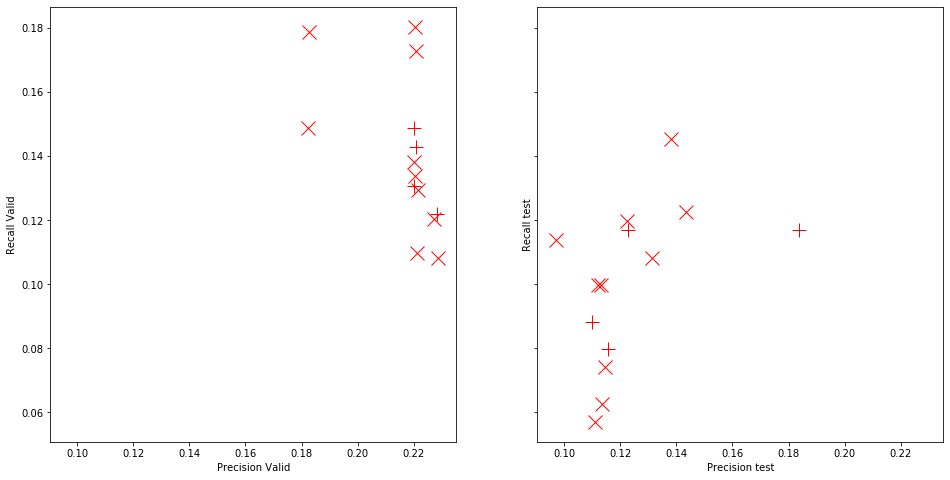

In [15]:
f, axs = plt.subplots(1, 2, figsize=(8*2, 8), sharex=True, sharey=True)
colors=['r', 'g', 'b']
markers = ['+', 'x']
for kk, l2 in enumerate(['0.001', '1e']):
    for jj, lamb in enumerate([0.25, 0.375, 0.5]):
        ind=(lamb_arr==lamb)&(l2_arr==l2)
        axs[0].plot(np.array(precision_valid_list)[ind], np.array(recall_valid_list)[ind], '.', 
                    color=colors[jj], marker=markers[kk], markersize=14)
        axs[0].set_xlabel('Precision Valid')
        axs[0].set_ylabel('Recall Valid')
        axs[1].plot(np.array(precision_test_list)[ind], np.array(recall_test_list)[ind], '.',
                   color=colors[jj], marker=markers[kk], markersize=14)
        axs[1].set_xlabel('Precision test')
        axs[1].set_ylabel('Recall test')

In [40]:
l2_arr

array(['0.001', '0.001', '1e', '1e', '1e', '0.001', '1e', '1e', '0.001',
       '0.001', '0.001', '1e', '0.001', '0.001', '1e', '0.001'],
      dtype='<U5')

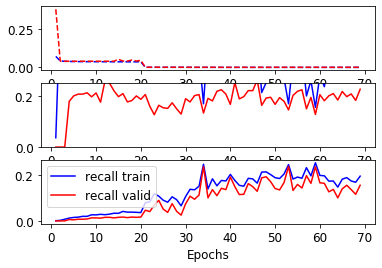

In [25]:
fname='skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=7437-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=truehistory.json'
mlp_dict=json.load(open(os.path.join(RESULTS_COLLAPSED_FEAT_DYNAMIC_INPUT_OUTPUT_PATH_MLP, fname)))

f, axs_list = plt.subplots(3, 1)
epochs=[i['epoch'] for i in mlp_dict[:-1]]
train_loss = [i['train_loss'] for i in mlp_dict[:-1]]
valid_loss = [i['valid_loss'] for i in mlp_dict[:-1]]
precision_train = [i['precision_train'] for i in mlp_dict[:-1]]
precision_valid = [i['precision_valid'] for i in mlp_dict[:-1]]
recall_train = [i['recall_train'] for i in mlp_dict[:-1]]
recall_valid = [i['recall_valid'] for i in mlp_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs_list[0].plot(epochs, train_loss, 'b--', label='train loss')
axs_list[0].plot(epochs, valid_loss, 'r--', label='valid loss')
axs_list[0].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
axs_list[1].plot(epochs, precision_train, 'b', label='precision train')
axs_list[1].plot(epochs, precision_valid, 'r', label='precision valid')
axs_list[2].plot(epochs, recall_train, 'b', label='recall train')
axs_list[2].plot(epochs, recall_valid, 'r', label='recall valid')
axs_list[2].set_xlabel('Epochs')
axs_list[1].set_ylim([0, 0.25])
axs_list[2].legend()


In [11]:
pd.DataFrame({'precision_valid':np.array(precision_valid_list),
             'precision_test' : np.array(precision_test_list),
             'recall_valid' : np.array(recall_valid_list),
             'recall_test' : np.array(recall_test_list),
             'fname' : perf_csvs})

,precision_valid,precision_test,recall_valid,recall_test,fname
0,0.220149,0.247544,0.139976,0.182874,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=23124-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
1,0.220493,0.216000,0.201661,0.235123,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=5781-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
2,0.292419,0.259939,0.096085,0.123367,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=46788-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
3,0.313043,0.348624,0.085409,0.110305,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=7437-lamb=0.5-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
4,0.309859,0.340659,0.078292,0.089985,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=46788-lamb=0.5-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
5,0.220513,0.213687,0.204033,0.222061,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=9091-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
6,0.154472,0.155172,0.045077,0.039187,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=7437-lamb=0.375-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
7,0.327586,0.303738,0.090154,0.094340,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=23124-lamb=0.5-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
8,0.220960,0.204866,0.207592,0.232221,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=5666-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
9,0.293233,0.295082,0.138790,0.156749,/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=8577-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv


In [16]:
pd.DataFrame({'precision_valid':np.array(precision_valid_list),
             'precision_test' : np.array(precision_test_list),
             'recall_valid' : np.array(recall_valid_list),
             'recall_test' : np.array(recall_test_list),
             'fname' : perf_csvs})

,precision_valid,precision_test,recall_valid,recall_test,fname
0,0.182320,0.097087,0.148872,0.113960,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=5781-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
1,0.220096,0.113269,0.138346,0.099715,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=9091-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
2,0.220930,0.122754,0.142857,0.116809,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=8577-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
3,0.221212,0.114537,0.109774,0.074074,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=156-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
4,0.220729,0.143333,0.172932,0.122507,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=7437-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
5,0.221649,0.131488,0.129323,0.108262,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=9-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
6,0.220297,0.112179,0.133835,0.099715,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=5212-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
7,0.220000,0.115702,0.148872,0.079772,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=5212-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
8,0.227273,0.113402,0.120301,0.062678,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=1e-07-batch_size=512-scoring=surrogate_loss_tight-seed=8577-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv
9,0.228169,0.183857,0.121805,0.116809,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/skorch_mlp/skorch_mlp_lr=1e-08-weight_decay=0.001-batch_size=512-scoring=surrogate_loss_tight-seed=7437-lamb=0.25-initialization_gain=0.25-n_hiddens=8-n_layers=1-warm_start=true_perf.csv


In [21]:
pd.DataFrame({'precision_valid':np.array(precision_valid_list),
             'precision_test' : np.array(precision_test_list),
             'recall_valid' : np.array(recall_valid_list),
             'recall_test' : np.array(recall_test_list),
             'fname' : perf_csvs})

,precision_valid,precision_test,recall_valid,recall_test,fname
0,0.214194,0.189655,0.249624,0.219373,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=1024-max_leaves=32-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.csv
1,0.204082,0.156695,0.225564,0.156695,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=128-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv
2,0.203310,0.180000,0.129323,0.076923,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=32-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv
3,0.205128,0.186147,0.156391,0.122507,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=4096-max_leaves=8-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.csv
4,0.206154,0.169279,0.201504,0.153846,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=4096-max_leaves=8-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.66_perf.csv
5,0.208396,0.176667,0.209023,0.150997,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=8-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.csv
6,0.202670,0.157518,0.251128,0.188034,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=1024-max_leaves=128-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.66_perf.csv
7,0.210291,0.187879,0.141353,0.088319,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=1024-max_leaves=32-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv
8,0.207634,0.158192,0.204511,0.159544,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=128-max_leaves=32-n_estimators=100-frac_features_for_clf=0.33-frac_training_samples_per_tree=0.33_perf.csv
9,0.210674,0.190349,0.225564,0.202279,/home/prash/results/madrid/v20211018/HIL/split-by=patient_id/collapsed_features_dynamic_input_output/lightGBM/lightGBM_min_samples_per_leaf=4096-max_leaves=32-n_estimators=100-frac_features_for_clf=0.66-frac_training_samples_per_tree=0.66_perf.csv
